# **I. Import libraries, prepare environment and load data**

## 1. Import libaries

In [ ]:
!pip install torchinfo

In [ ]:
import copy
import os
import random
import glob
#import wandb
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, classification_report, accuracy_score
from typing import Dict, Tuple, List
import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, Dataset
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.optim as optim
import torchinfo
import albumentations as A
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings("ignore")

In [ ]:
base = nn.Identity()
base

Identity()

In [ ]:
# setting up device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## 2. Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data dir
ROOT_DIR = '/content/drive/MyDrive/Milan-Urban-Farming/Task3-Smart Pest Management/Data collection/Image Collection/orange - Swathy/Orange fruit_Split'
print(os.listdir(ROOT_DIR ))

['train', 'test', 'validation']


## 3. Creating Custom Dataset for PyTorch DataLoading

In [ ]:
# CustomDataset class for multi-class image classification
class CustomDataset(Dataset):


    def __init__(self, root_dir: str, split: str, transform=None, resize=None):
        """
        Custom dataset class for multi-class image classification.

        Args:
            root_dir (str): Root directory containing the dataset.
            split (str): Split (e.g., train, validation) of the dataset.
            transform (callable, optional): Optional transformation to apply to the data.
            resize (int, optional): Resize dimensions (width, height) for the images.

        Attributes:
            root_dir (str): Root directory containing the dataset.
            split (str): Split (e.g., train, validation) of the dataset.
            transform (callable, optional): Optional transformation to apply to the data.
            resize (int, optional): Resize dimensions (width, height) for the images.
            data (list): List of image paths.
            targets (list): List of target labels.
            class_names (list): List of class names.
            class_idx_to_name (dict): Dictionary mapping class indices to class names.

        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.resize = resize
        self.data = []
        self.targets = []
        self.class_names = []


        # Determine the data directory based on the split
        data_dir = os.path.join(root_dir, split)

        # Walk through the class subfolders
        class_dirs = sorted(os.listdir(data_dir))
        for class_idx, class_dir in enumerate(class_dirs):
            class_path = os.path.join(data_dir, class_dir)
            self.class_names.append(class_dir)

            # Walk through the images in each class subfolder
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.data.append(img_path)
                self.targets.append(class_idx)
        # Create a dictionary to map class indices to class names
        self.class_idx_to_name = {idx: name for idx, name in enumerate(self.class_names)}
        # Method to get the length of the dataset
    def __len__(self):
        """
        Get the length of the dataset.

        Returns:
            int: The number of images in the dataset.
        """
        return len(self.data)

    # Method to get a specific item from the dataset
    def __getitem__(self, idx):
        """
        Get a specific item from the dataset.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            tuple: A tuple containing the processed image and its target label.
                If an error occurs during image loading or processing, returns (None, None).
        """
        img_path = self.data[idx]
        target = self.targets[idx]

        try:
            image = cv2.imread(img_path)

            if self.resize is not None:
                image = cv2.resize(image, (self.resize, self.resize))

            if self.transform is not None:
                image = self.transform(image=image)['image']

            return image, target

        except Exception as e:
            print(f"Error loading image: {e}")
            return None, None

    def num_classes(self):
        """
        Get the number of classes in the dataset.

        Returns:
            int: Number of classes.
        """
        return len(self.class_names)


    def get_class_name(self, class_idx):
        """
        Get the class name based on its index.

        Args:
            class_idx (int): Index of the class.

        Returns:
            str: The name of the class.
        """
        return self.class_idx_to_name.get(class_idx)

    def get_class_names(self):
        """
        Get all class names in the dataset.

        Returns:
            list: A list of class names.
        """
        return list(self.class_idx_to_name.values())

    def class_idx_to_name_dict(self):
        """
        Get a dictionary mapping class indices to class names.

        Returns:
            dict: A dictionary mapping class indices to class names.
        """
        return self.class_idx_to_name



    def get_class_frequencies(self):
        """
        Calculate and return a dictionary containing the number of samples for each class.

        Returns:
            dict: A dictionary with class indices as keys and sample counts as values.
        """
        class_counts = {}
        for label in self.targets:
            if label not in class_counts:
                class_counts[label] = 0
            class_counts[label] += 1
        return class_counts


# **II. Model training**

## **1. Necessary Functions**

### 1.1. Image Augmentations

In [ ]:
def get_transforms(config:Dict, augment=True):
    """
    Get data augmentation and transformation pipelines for image data.

    Args:
        augment (bool, optional): Whether to apply data augmentation. Default is True.

    Returns:
        tuple: A tuple containing the training and validation transformation pipelines.

    Notes:
        - If augment is True, applies a set of augmentation techniques including horizontal flip, vertical flip,
          random rotation, random brightness/contrast adjustments, hue/saturation/value adjustments, noise addition,
          CLAHE, and normalization with specified mean and standard deviation.
        - If augment is False, applies only normalization with specified mean and standard deviation.

    Example:
        train_transform = get_transforms(augment=True)
    """
    if augment:
        transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.3),
            A.RandomBrightnessContrast(brightness_limit=(-0.15,0.15), contrast_limit=(-0.15, 0.15), p=0.3),
            #A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=30, val_shift_limit=20, p=0.2),
            A.GaussNoise(var_limit=(10, 50), p=0.1),
            A.CLAHE(clip_limit=(1,3), tile_grid_size=(8, 8), p=0.3),
            #A.RandomCrop(224, 224, 0.3),  # RandomCrop to introduce variability
            A.CenterCrop(height=config['crop'], width=config['crop']),  # CenterCrop to focus on central area
            # choose mean and std based on pre-trained model specification.
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
            ])
    else:
        transform = A.Compose([
            A.CenterCrop(height=config['crop'], width=config['crop']),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])


    return transform

### 1.2. Model Training Loop

In [ ]:
def train_model(model, dataloader, optimizer, loss_fn, device):
    """
    Trains a model on a given dataset using a specified optimizer and loss function.

    Args:
        model (torchvision.models): The model to be trained.
        dataloader (DataLoader): The data loader for the training dataset.
        optimizer (optim.Optimizer): The optimizer used to update the model parameters.
        loss_fn (nn.Module): The loss function used to calculate the loss.
        device (torch.device): The device (e.g., GPU or CPU) to use for training.

    Returns:
        dict: A dictionary containing the training results, including the average loss, accuracy, precision, recall, and F1-score.
    """

    # Set the model to training mode
    model.train()

    # Initialize running totals for loss and correct predictions
    running_loss = 0.0
    running_corrects = 0
    true_labels, predicted_labels = [], []

    # Loop over the data
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss and correct predictions
        running_loss += loss.item() * images.size(0)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

        # Collect true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(outputs.argmax(dim=1).cpu().numpy())

    # Calculate average loss and accuracy over the entire dataset
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    # Return detailed training results
    training_results = {
        'Loss': epoch_loss,
        'Accuracy': epoch_acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Macro': f1,
    }

    return training_results

### 1.3. Model Validation Loop

In [ ]:
def validate_model(model, dataloader, loss_fn, device):
    """
    Evaluates the model on a validation dataset.

    Args:
        model (torch.nn.Module): The model to be evaluated.
        dataloader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        loss_fn (torch.nn.Module): Loss function to evaluate the model's performance.
        device (str): Device to perform computations on (e.g., 'cpu' or 'cuda').

    Returns:
        dict: A dictionary containing the average loss, accuracy, precision, recall, and F1 score (macro).
    """

    # Set the model to evaluation mode
    model.eval()

    # Initialize running totals for loss and correct predictions
    running_loss = 0.0
    running_corrects = 0
    true_labels, predicted_labels = [], []

    # Disable gradient calculation for validation
    with torch.no_grad():
        # Loop over the data
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Accumulate loss and correct predictions
            running_loss += loss.item() * images.size(0)
            running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

            # Collect true and predicted labels
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(outputs.argmax(dim=1).cpu().numpy())

    # Calculate average loss and accuracy over the entire dataset
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    # Return detailed validation results
    validation_results = {
        'Loss': epoch_loss,
        'Accuracy': epoch_acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Macro': f1,
    }

    # Reset the model to training mode
    model.train()

    return validation_results

### 1.4. Early Stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

### 1.5. Training Pipeline

In [ ]:
def training_pipeline(config:Dict,
                      model:models,
                      train_loader:DataLoader,
                      valid_loader:DataLoader,
                      optimizer:optim.Optimizer,
                      loss_fn:nn.Module,
                      early_stopping: None or object,
                      device:str):
    """
    Function to manage the training pipeline of a machine learning model.

    Args:
        config (Dict): A dictionary containing configuration parameters, including the number of epochs.
        model (torchvision.models): The model to be trained.
        train_loader (DataLoader): DataLoader for the training dataset.
        valid_loader (DataLoader): DataLoader for the validation dataset.
        optimizer (optim.Optimizer): Optimizer for model parameter updates.
        loss_fn (nn.Module): Loss function to evaluate the model's performance.
        device (str): Device to perform computations (e.g., 'cpu' or 'cuda').

    Returns:
        None
    """
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'train_precision': [],
        'train_recall': [],
        'train_f1': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }
    best_val_f1 = 0.0
    best_model_state_dict = None

    for epoch in tqdm(range(config['epochs'])):
        print(f'Epoch {epoch + 1}/{config["epochs"]}')
        print('-' * 10)

        train_res = train_model(model=model,
                                dataloader=train_loader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

        print(f"Train - Loss: {train_res['Loss']:.4f}, Accuracy: {train_res['Accuracy']:.4f}, Precision: {train_res['Precision']:.4f}, Recall: {train_res['Recall']:.4f}, F1 Score: {train_res['F1-Macro']:.4f}")

        val_res = validate_model(model=model,
                                dataloader=valid_loader,
                                loss_fn=loss_fn,
                                device=device)
        print(f"Validation - Loss: {val_res['Loss']:.4f}, Accuracy: {val_res['Accuracy']:.4f}, Precision: {val_res['Precision']:.4f}, Recall: {val_res['Recall']:.4f}, F1 Score: {val_res['F1-Macro']:.4f}")

         # Save the results
        history['train_loss'].append(train_res['Loss'])
        history['train_accuracy'].append(train_res['Accuracy'])
        history['train_precision'].append(train_res['Precision'])
        history['train_recall'].append(train_res['Recall'])
        history['train_f1'].append(train_res['F1-Macro'])

        history['val_loss'].append(val_res['Loss'])
        history['val_accuracy'].append(val_res['Accuracy'])
        history['val_precision'].append(val_res['Precision'])
        history['val_recall'].append(val_res['Recall'])
        history['val_f1'].append(val_res['F1-Macro'])

        # Check early stopping
        if early_stopping:
            if early_stopping(model, val_res['Loss']):
                print(early_stopping.status)
                break
            else:
                print(early_stopping.status)

        # Deep copy the model if it has the best F1 score so far
        if val_res['F1-Macro'] > best_val_f1:
            best_val_f1 = val_res['F1-Macro']
            best_model_state_dict = copy.deepcopy(model.state_dict())
        print()

    # Ensure best model weights are available before loading
    # Load best model weights for validation loss (if applicable)
    if early_stopping and early_stopping.restore_best_weights:
        if early_stopping.best_model is not None:
            model.load_state_dict(early_stopping.best_model)
        else:
            print("Warning: No best model found in early stopping.")
    elif best_model_state_dict is not None:
        model.load_state_dict(best_model_state_dict)
    else:
        print("Warning: No best model found to load.")

     # Load best model weights for validation loss (if applicable)
     #if early_stopping and early_stopping.restore_best_weights:
     #    model.load_state_dict(early_stopping.best_model)
     #else:
     #   model.load_state_dict(best_model_state_dict)

    # Save the best model after after training and validation
    if best_model_state_dict is not None:
        torch.save(best_model_state_dict, os.path.join('/content/drive/MyDrive/Orange Task 3', config['weights_path']))

    return history

### 1.6. Plotting Training Results

In [ ]:
def plot_training_results(history):
  """
  Plot training and validation loss and F1-score from training history.

  Args:
      history (Dict): Dictionary containing training and validation results for each epoch.
          Expected keys: 'train_loss', 'val_loss', 'train_f1', 'val_f1'
  """
  plt.figure(figsize=(20, 12))

  # Plot loss
  plt.subplot(2, 1, 1)
  plt.plot(history['train_loss'], label='Train Loss')
  plt.plot(history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  # Plot F1-score
  plt.subplot(2, 1, 2)
  plt.plot(history['train_f1'], label='Train F1-Score')
  plt.plot(history['val_f1'], label='Validation F1-Score')
  plt.xlabel('Epoch')
  plt.ylabel('F1-Score')
  plt.title('Training and Validation F1-Score')
  plt.legend()

  plt.tight_layout()
  plt.show()

### 1.7. Evaluation

In [ ]:
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)

    # Additional per-class evaluation (optional)
    class_report = classification_report(y_true, y_pred)

    return cm, f1_macro, precision, recall, accuracy, class_report

In [ ]:
def plot_cm(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(20,15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Set3',xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

## **2. Model Training without Augmentation**

- ***Resnet 18:*** (from previous modeling)

  - Train: Accuracy: 0.8216, Precision: 0.3123, Recall: 0.3500, F1 Score: 0.3281
  - Validation: Accuracy: 0.8105, Precision: 0.3173, Recall: 0.3405, F1 Score: 0.3227
  - Testing: Accuracy - 0.8089, Precision - 0.3209, Recall - 0.3536, F1 Score - 0.3342

- ***Efficient Net:***

  - Train: Accuracy: 0.9956, Precision: 0.9956, Recall: 0.9958, F1 Score: 0.9957
  - Validation: Accuracy: 0.9424, Precision: 0.8331, Recall: 0.8678, F1 Score: 0.8252
  - Testing: Accuracy: 0.8466, Precision: 0.7664, Recall: 0.8239, F1 Score: 0.7238

- ***Efficient Net B7:***

  - Train: Accuracy: 0.9902, Precision: 0.9908, Recall: 0.9897, F1 Score: 0.9902
  - Validation: Accuracy: 0.9353, Precision: 0.7393, Recall: 0.8365, F1 Score: 0.7705
  - Testing: Accuracy: 0.8344, Precision: 0.7297, Recall: 0.8216, F1 Score: 0.7278

### **2.1. Training preparation**

#### **A. Training preparation**

In [ ]:
# Check if the directory exists
if not os.path.exists(ROOT_DIR):
    raise FileNotFoundError("Directory does not exist:", ROOT_DIR)

# Check if the train directory exists
if not os.path.exists(os.path.join(ROOT_DIR, 'train')):
    raise FileNotFoundError("Train directory does not exist:", os.path.join(ROOT_DIR, 'train'))

In [ ]:
es = EarlyStopping(patience=5, min_delta=0.01, restore_best_weights=False)

### **2.2. EfficientNet B1**

In [ ]:
# tweak these and experiment with different values.
config_ef = dict(
    resize =256,
    crop = 240,
    augment= False,
    epochs = 50,
    batch_size = 32,
    lr = 0.001,
    dropout = 0.2,
    weights_path = 'weights_basic_EFnet.pth'
)

In [ ]:
# get transforms
config=config_ef
train_transform = get_transforms(augment=config['augment'], config=config)
valid_transform = get_transforms(augment=config['augment'], config=config)
# dataset
train_dataset = CustomDataset(root_dir=ROOT_DIR, split='train',resize=config['resize'], transform=train_transform)
valid_dataset = CustomDataset(root_dir=ROOT_DIR, split='validation', resize=config['resize'], transform=valid_transform)
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=config_ef['batch_size'], shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=4)

In [ ]:
num_classes = train_dataset.num_classes()
print("No. of Classes : ", num_classes)

No. of Classes :  8


In [ ]:
class_map = train_dataset.class_idx_to_name_dict()
print("Class Index to class name map: \n")
class_map

Class Index to class name map: 



{0: 'Black spot',
 1: 'Canker',
 2: 'Greening',
 3: 'Scab',
 4: 'bacteria _citrus',
 5: 'fungus_penicillium',
 6: 'healthy',
 7: 'pest_psyllid'}

In [ ]:
# class frequencies
class_freq = train_loader.dataset.get_class_frequencies()

total_samples = sum(class_freq.values())
num_classes = len(class_freq)

class_weights = [round(total_samples / (num_classes * class_freq[i]), 4) for i in range(num_classes)]
print(class_weights)

[0.7826, 0.6317, 0.4574, 11.7396, 6.125, 4.1434, 0.4295, 7.4145]


In [ ]:
# Assign Weights to Each Sample
sample_weights = [class_weights[label] for _, label in train_loader.dataset] # The class weights are calculated in: 2.2.ResNet 18

# Convert list of sample weights to a Torch tensor
sample_weights = torch.tensor(sample_weights)

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Dataloaders setup
train_loader_balanced = DataLoader(train_dataset, batch_size=config_ef['batch_size'], sampler=sampler, num_workers=4)

In [ ]:
model_ef = models.efficientnet_b1(weights='DEFAULT', progress=True)
num_ftrs = model_ef.classifier[1].in_features
# Freeze the pre-trained model parameters
for param in model_ef.parameters():
    param.requires_grad = False
model_ef.classifier = nn.Sequential(
                nn.Dropout(p=config["dropout"], inplace=True),
                nn.Linear(num_ftrs, 1024),
                nn.ReLU(),
                nn.Dropout(p=config["dropout"]),
                nn.Linear(1024, num_classes)
            )
model_ef = model_ef.to(device)

In [ ]:
# define optimizer and loss funtion
optimizer_ef = optim.Adam(params=model_ef.parameters(), lr=config['lr'])
loss_fn = nn.CrossEntropyLoss()

In [ ]:
history_2  = training_pipeline(config=config_ef,
                  model = model_ef,
                  train_loader=train_loader_balanced,
                  valid_loader=valid_loader,
                  optimizer=optimizer_ef,
                  loss_fn=loss_fn,
                  early_stopping=None,
                  device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50
----------
Train - Loss: 0.9087, Accuracy: 0.8012, Precision: 0.8022, Recall: 0.7909, F1 Score: 0.7810
Validation - Loss: 0.4055, Accuracy: 0.8633, Precision: 0.7187, Recall: 0.8718, F1 Score: 0.7421

Epoch 2/50
----------
Train - Loss: 0.1894, Accuracy: 0.9441, Precision: 0.9430, Recall: 0.9423, F1 Score: 0.9416
Validation - Loss: 0.2619, Accuracy: 0.9137, Precision: 0.7394, Recall: 0.8499, F1 Score: 0.7777

Epoch 3/50
----------
Train - Loss: 0.1218, Accuracy: 0.9681, Precision: 0.9679, Recall: 0.9672, F1 Score: 0.9674
Validation - Loss: 0.2516, Accuracy: 0.9137, Precision: 0.7223, Recall: 0.8475, F1 Score: 0.7617

Epoch 4/50
----------
Train - Loss: 0.0864, Accuracy: 0.9716, Precision: 0.9742, Recall: 0.9743, F1 Score: 0.9741
Validation - Loss: 0.2473, Accuracy: 0.9137, Precision: 0.7253, Recall: 0.8511, F1 Score: 0.7688

Epoch 5/50
----------
Train - Loss: 0.0920, Accuracy: 0.9698, Precision: 0.9676, Recall: 0.9679, F1 Score: 0.9676
Validation - Loss: 0.2099, Accuracy: 0

In [ ]:
#dataset
test_dataset = CustomDataset(root_dir=ROOT_DIR, split='test',resize=config_ef['resize'], transform=valid_transform)
# dataloaders
test_loader = DataLoader(test_dataset, batch_size=config_ef['batch_size'], shuffle=False, num_workers=4)

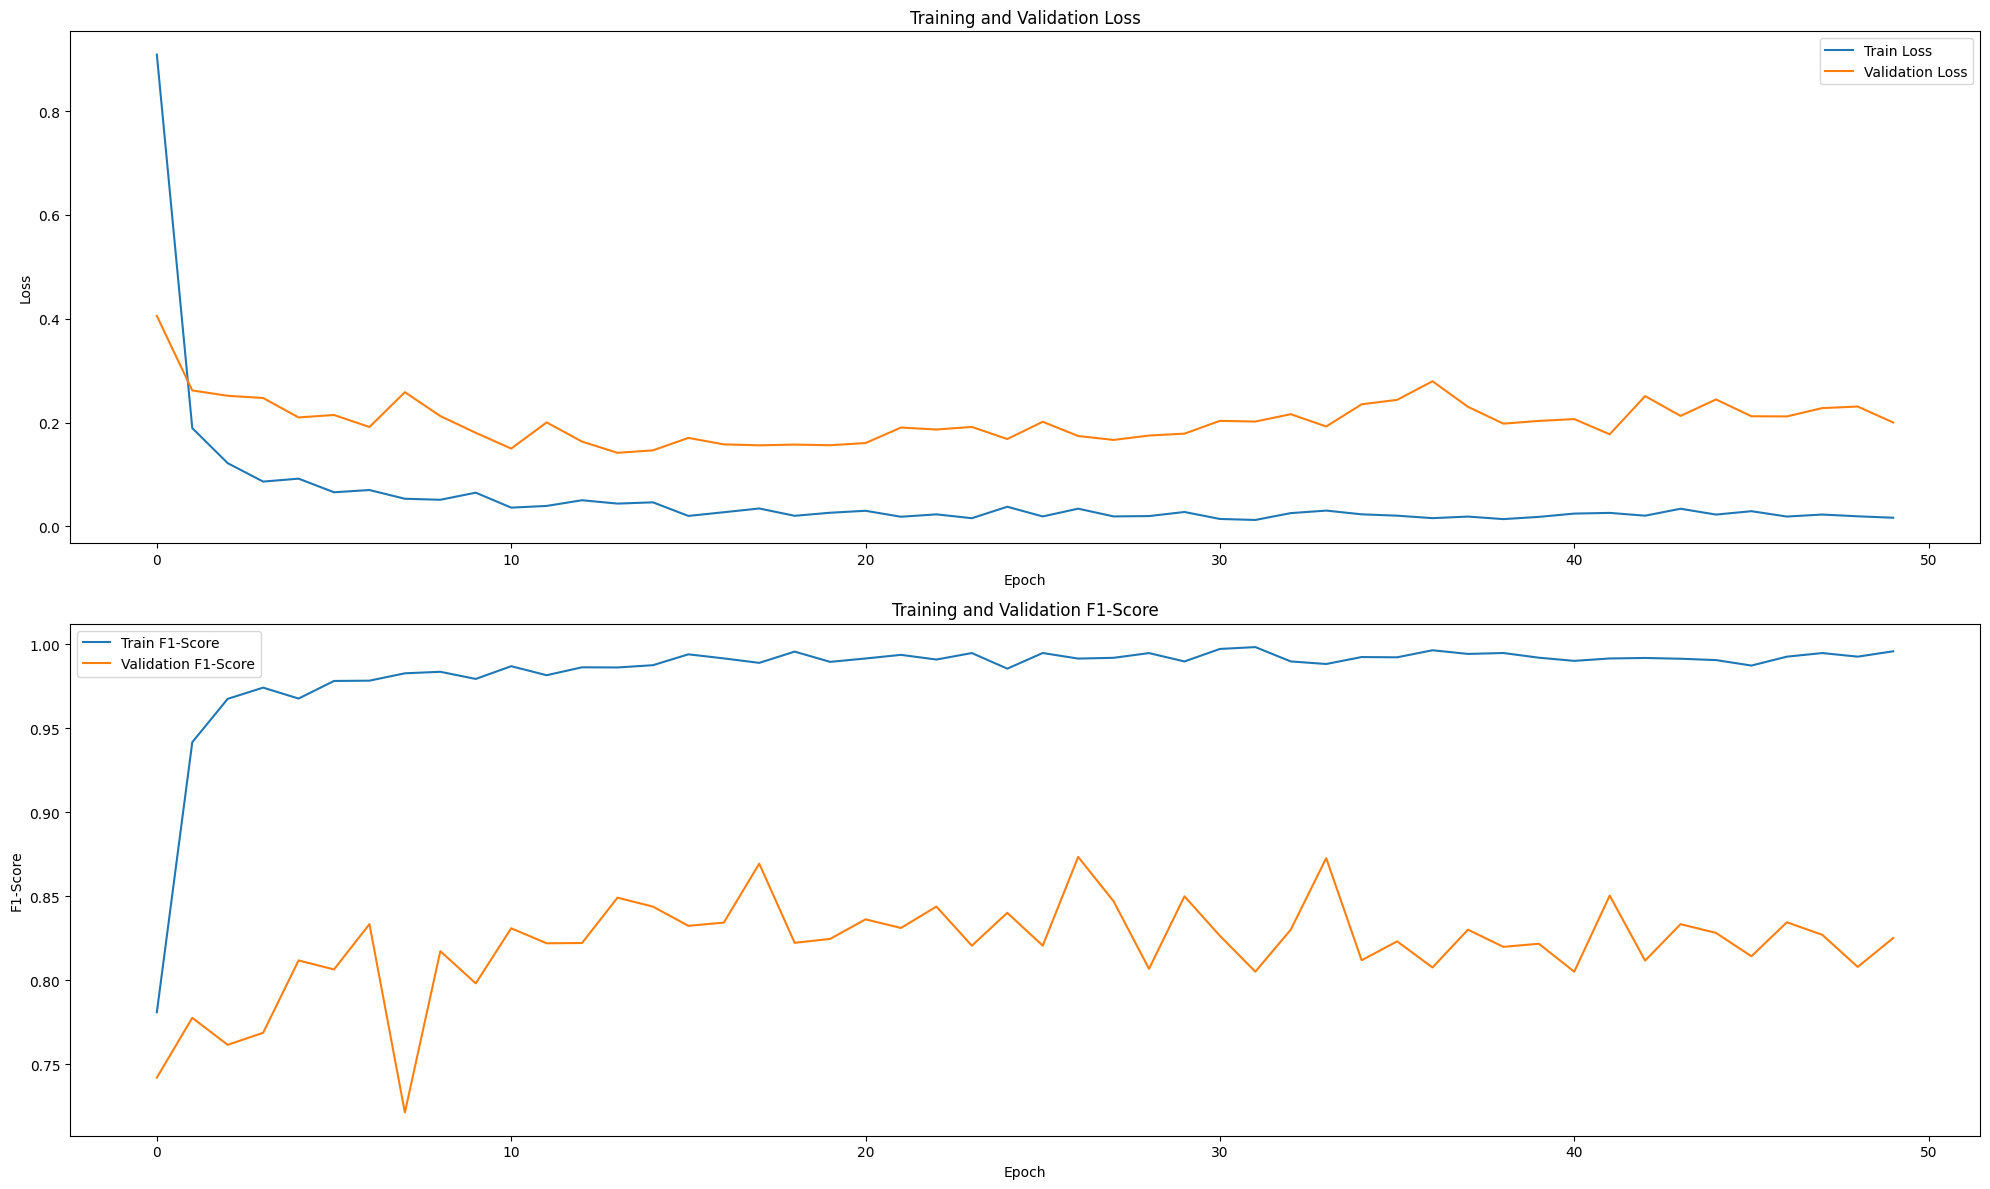

In [ ]:
plot_training_results(history=history_2)

In [ ]:
cm, f1_macro, precision, recall, accuracy, class_report = evaluate_model(model=model_ef, test_loader=test_loader, device='cuda')
print(f"Evaluation Results -  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_macro:.4f}")
print("Classification Report : \n")
print(class_report)

Evaluation Results -  Accuracy: 0.8466, Precision: 0.7664, Recall: 0.8239, F1 Score: 0.7238
Classification Report : 

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        23
           1       0.89      0.89      0.89        28
           2       0.87      1.00      0.93        39
           3       1.00      0.14      0.25        21
           4       0.27      1.00      0.43         3
           5       0.71      1.00      0.83         5
           6       0.93      0.98      0.95        41
           7       0.50      0.67      0.57         3

    accuracy                           0.85       163
   macro avg       0.77      0.82      0.72       163
weighted avg       0.89      0.85      0.82       163



In [ ]:
classes = test_dataset.class_names
print(classes)

['Black spot', 'Canker', 'Greening', 'Scab', 'bacteria _citrus', 'fungus_penicillium', 'healthy', 'pest_psyllid']


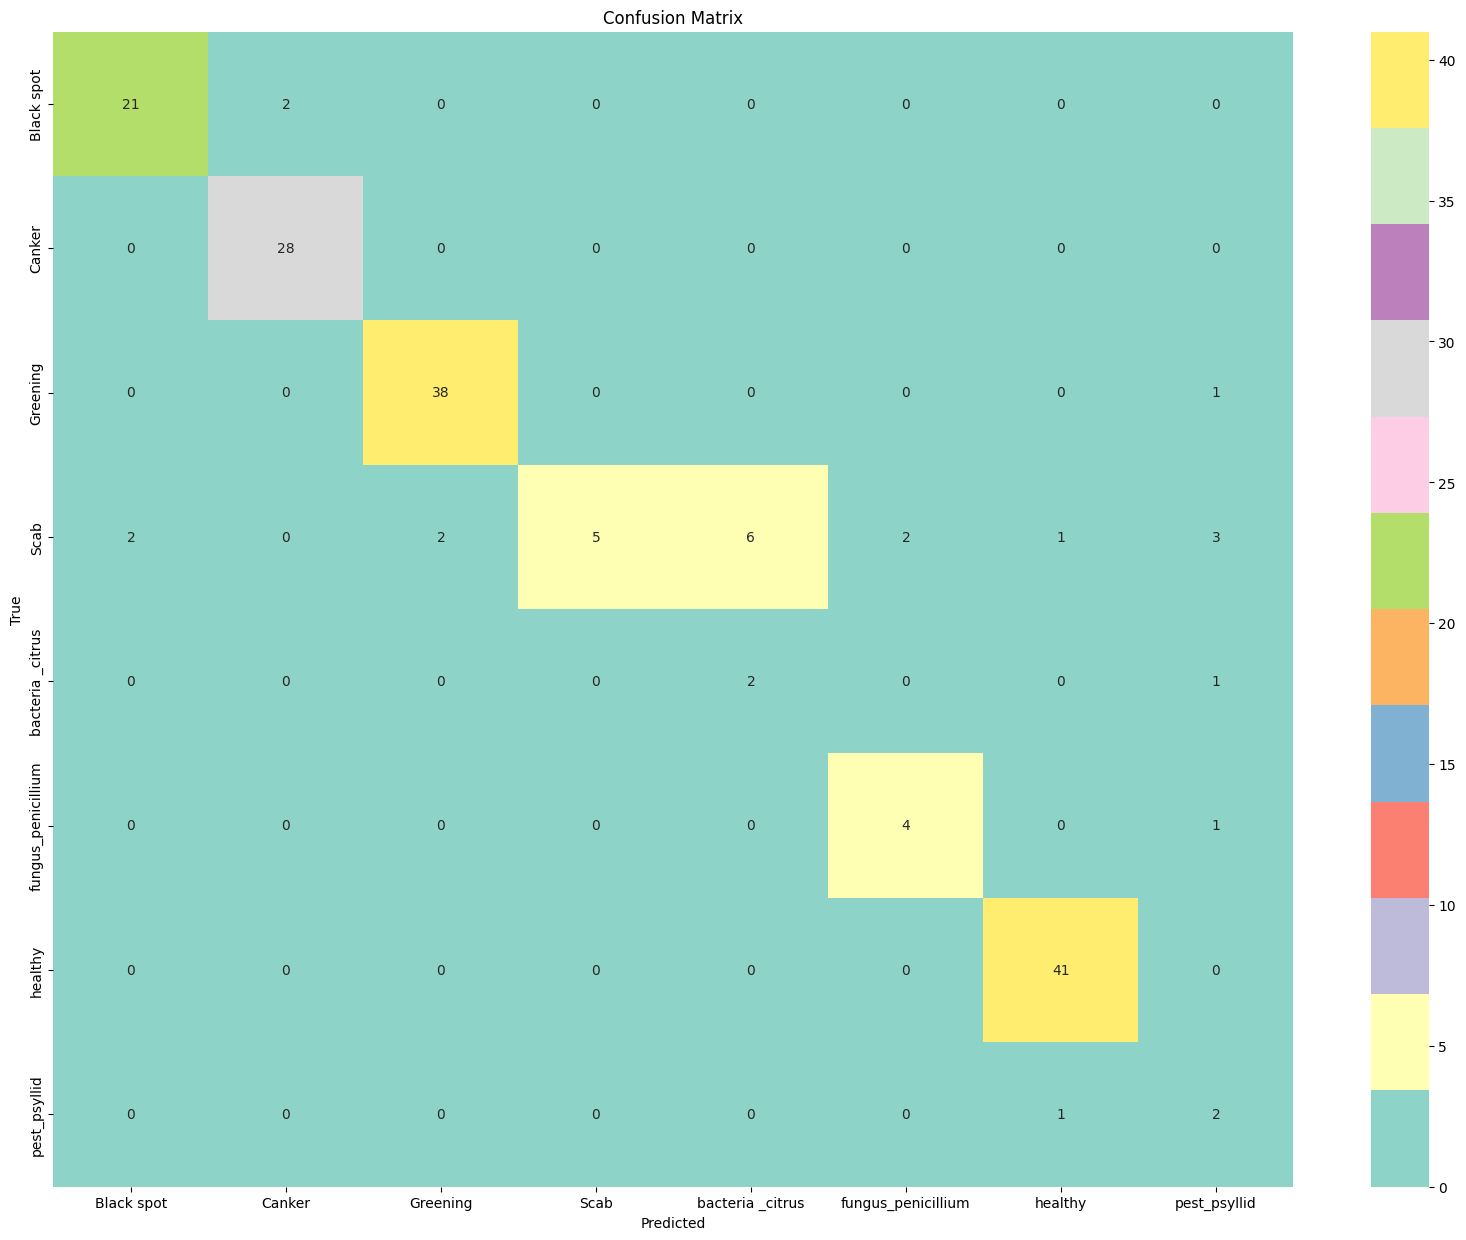

In [ ]:
# plot confusion matrix
plot_cm(cm, classes, title="Confusion Matrix")

### 2.3 Efficient Net B7


In [ ]:
# Efficient Net B7
config_ef_B7 = dict(
    resize = 256,
    crop = 240,
    augment= False,
    epochs = 50,
    batch_size = 32,
    lr = 0.001,
    dropout = 0.2,
    weights_path = 'weights_basic_efB7.pth'
)

In [ ]:
# Get transformations
train_transform = get_transforms(config=config_ef_B7, augment=config_ef_B7['augment'])
val_test_transform = get_transforms(config=config_ef_B7, augment=False)
# dataset
train_dataset = CustomDataset(root_dir=ROOT_DIR, split='train',resize=config_ef_B7['resize'], transform=train_transform)
valid_dataset = CustomDataset(root_dir=ROOT_DIR, split='validation',resize=config_ef_B7['resize'], transform=val_test_transform)
test_dataset = CustomDataset(root_dir=ROOT_DIR, split='test',resize=config_ef_B7['resize'], transform=val_test_transform )
# dataloaders
train_loader_balanced = DataLoader(train_dataset, batch_size=config_ef_B7['batch_size'], shuffle=False, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=config_ef_B7['batch_size'], shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=config_ef_B7['batch_size'], shuffle=False, num_workers=4)


In [ ]:
# Assign Weights to Each Sample
#sample_weights = [class_weights[label] for _, label in train_loader.dataset] # The class weights are calculated in: 2.2.ResNet 18

# Convert list of sample weights to a Torch tensor
#sample_weights = torch.tensor(sample_weights)

# Create WeightedRandomSampler
#sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Dataloaders setup
train_loader_balanced = DataLoader(train_dataset, batch_size=config_ef_B7['batch_size'], sampler=sampler, num_workers=4)

In [ ]:
model_ef_B7 = models.efficientnet_b7(weights='DEFAULT', progress=True)
num_ftrs = model_ef_B7.classifier[1].in_features
# Freeze the pre-trained model parameters
for param in model_ef_B7.parameters():
    param.requires_grad = False
model_ef_B7.classifier = nn.Sequential(
                nn.Dropout(p=config_ef_B7["dropout"], inplace=True),
                nn.Linear(num_ftrs, 1024),
                nn.ReLU(),
                nn.Dropout(p=config_ef_B7["dropout"]),
                nn.Linear(1024, num_classes)
            )
model_ef_B7 = model_ef_B7.to(device)

In [ ]:
# define optimizer and loss funtion
optimizer_ef_B7 = optim.AdamW(params=model_ef_B7.parameters(), lr=config_ef_B7['lr'])
loss_fn = nn.CrossEntropyLoss()
history_3  = training_pipeline(config=config_ef_B7,
                  model = model_ef_B7,
                  train_loader=train_loader_balanced,
                  valid_loader=valid_loader,
                  optimizer=optimizer_ef_B7,
                  loss_fn=loss_fn,
                  early_stopping=None,
                  device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50
----------
Train - Loss: 0.7766, Accuracy: 0.8021, Precision: 0.8059, Recall: 0.8061, F1 Score: 0.8041
Validation - Loss: 1.1304, Accuracy: 0.6331, Precision: 0.6660, Recall: 0.6377, F1 Score: 0.5765

Epoch 2/50
----------
Train - Loss: 0.2151, Accuracy: 0.9317, Precision: 0.9304, Recall: 0.9303, F1 Score: 0.9300
Validation - Loss: 0.6877, Accuracy: 0.7698, Precision: 0.7393, Recall: 0.7804, F1 Score: 0.6939

Epoch 3/50
----------
Train - Loss: 0.1642, Accuracy: 0.9468, Precision: 0.9463, Recall: 0.9458, F1 Score: 0.9459
Validation - Loss: 0.5430, Accuracy: 0.8058, Precision: 0.6186, Recall: 0.8035, F1 Score: 0.6582

Epoch 4/50
----------
Train - Loss: 0.1136, Accuracy: 0.9672, Precision: 0.9660, Recall: 0.9665, F1 Score: 0.9661
Validation - Loss: 0.4033, Accuracy: 0.8777, Precision: 0.6921, Recall: 0.8498, F1 Score: 0.7251

Epoch 5/50
----------
Train - Loss: 0.1441, Accuracy: 0.9485, Precision: 0.9522, Recall: 0.9522, F1 Score: 0.9521
Validation - Loss: 0.3134, Accuracy: 0

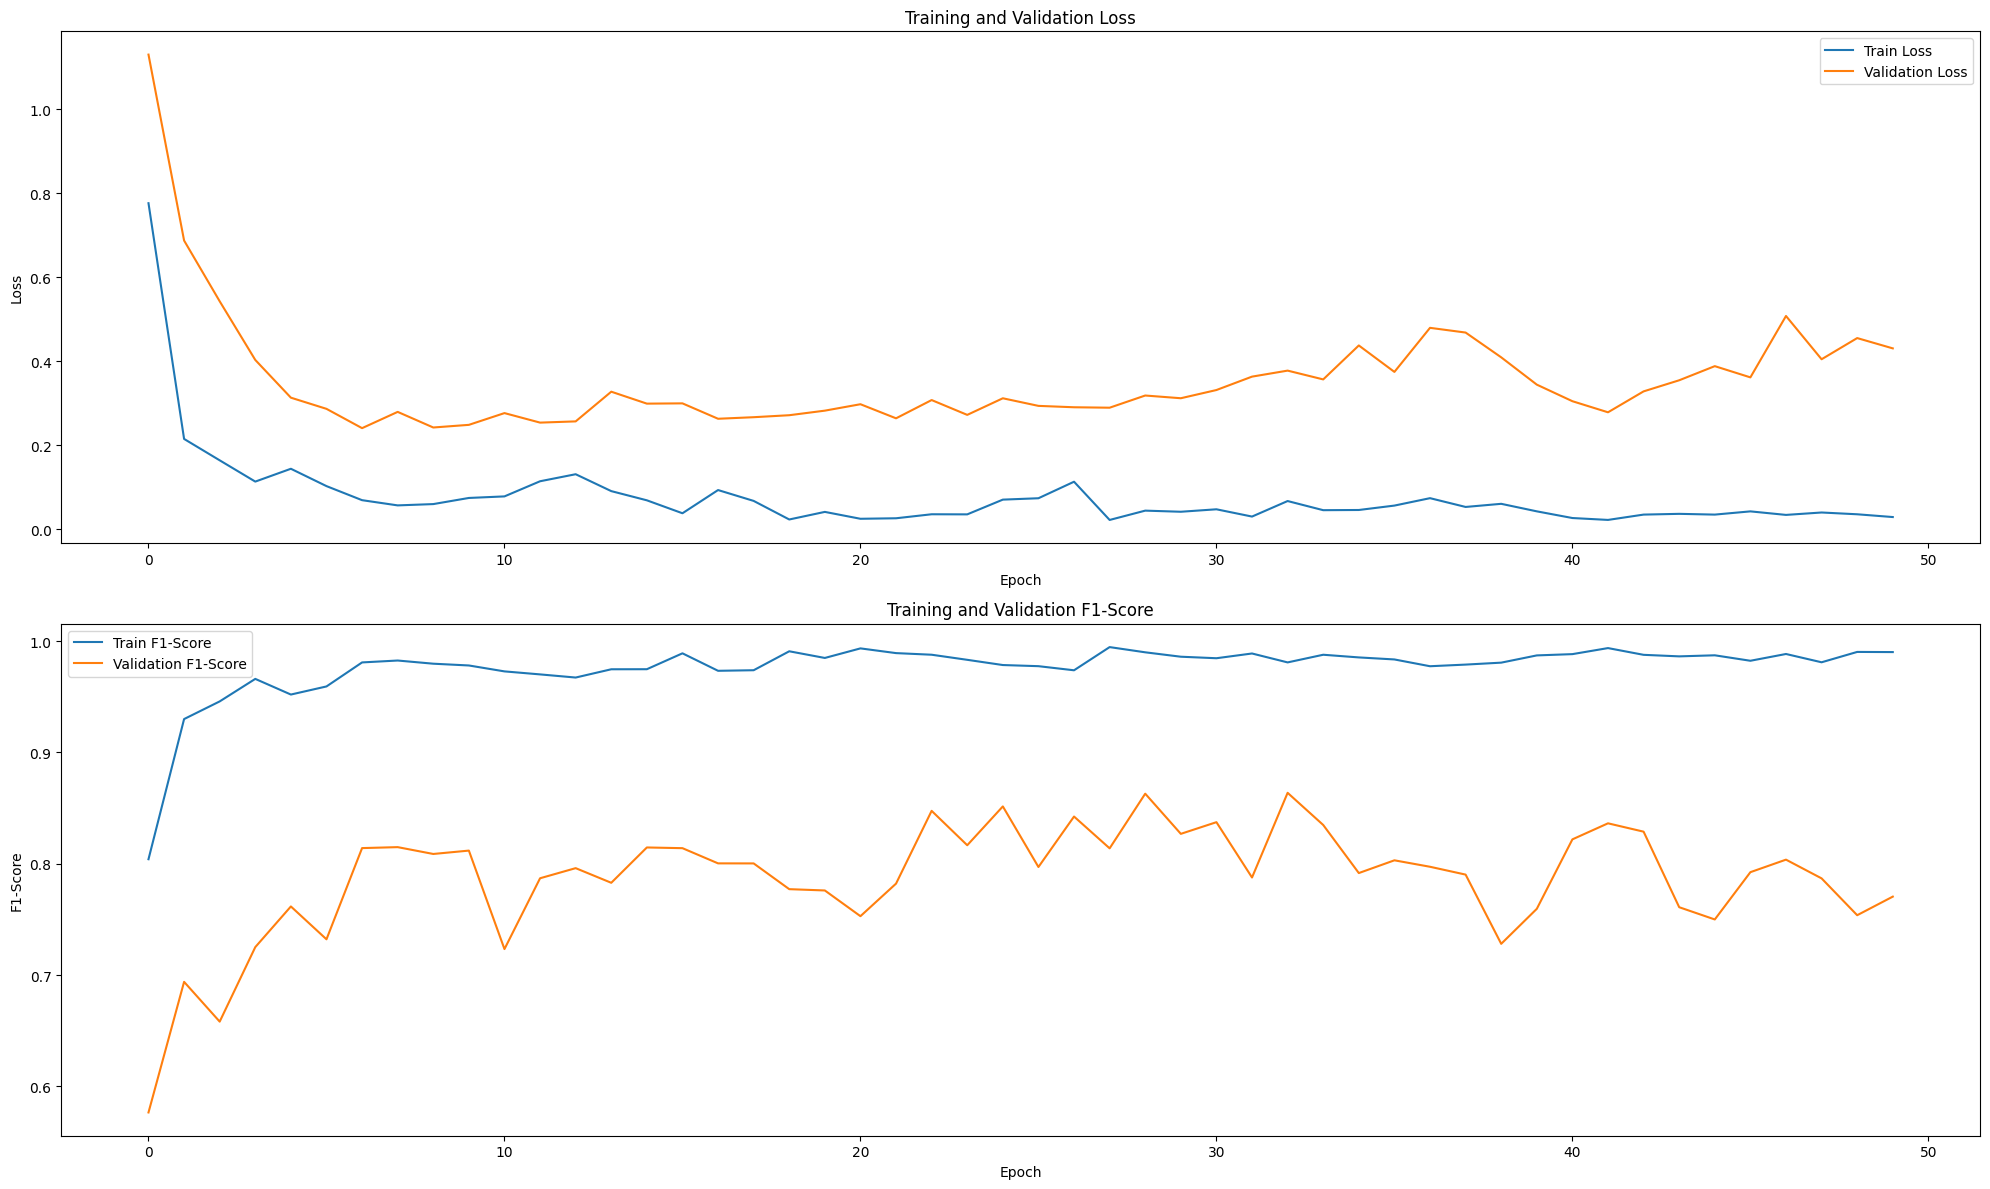

In [ ]:
plot_training_results(history=history_3)

In [ ]:
#dataset
test_dataset = CustomDataset(root_dir=ROOT_DIR, split='test',resize=config_ef_B7['resize'], transform=valid_transform)
# dataloaders
test_loader = DataLoader(test_dataset, batch_size=config_ef_B7['batch_size'], shuffle=False, num_workers=4)

In [ ]:
cm, f1_macro, precision, recall, accuracy, class_report = evaluate_model(model=model_ef_B7, test_loader=test_loader, device='cuda')
print(f"Evaluation Results -  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_macro:.4f}")
print("Classification Report : \n")
print(class_report)

Evaluation Results -  Accuracy: 0.8344, Precision: 0.7297, Recall: 0.8216, F1 Score: 0.7278
Classification Report : 

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        23
           1       0.81      0.93      0.87        28
           2       0.90      0.92      0.91        39
           3       0.80      0.19      0.31        21
           4       0.43      1.00      0.60         3
           5       0.56      1.00      0.71         5
           6       0.89      0.95      0.92        41
           7       0.50      0.67      0.57         3

    accuracy                           0.83       163
   macro avg       0.73      0.82      0.73       163
weighted avg       0.85      0.83      0.81       163



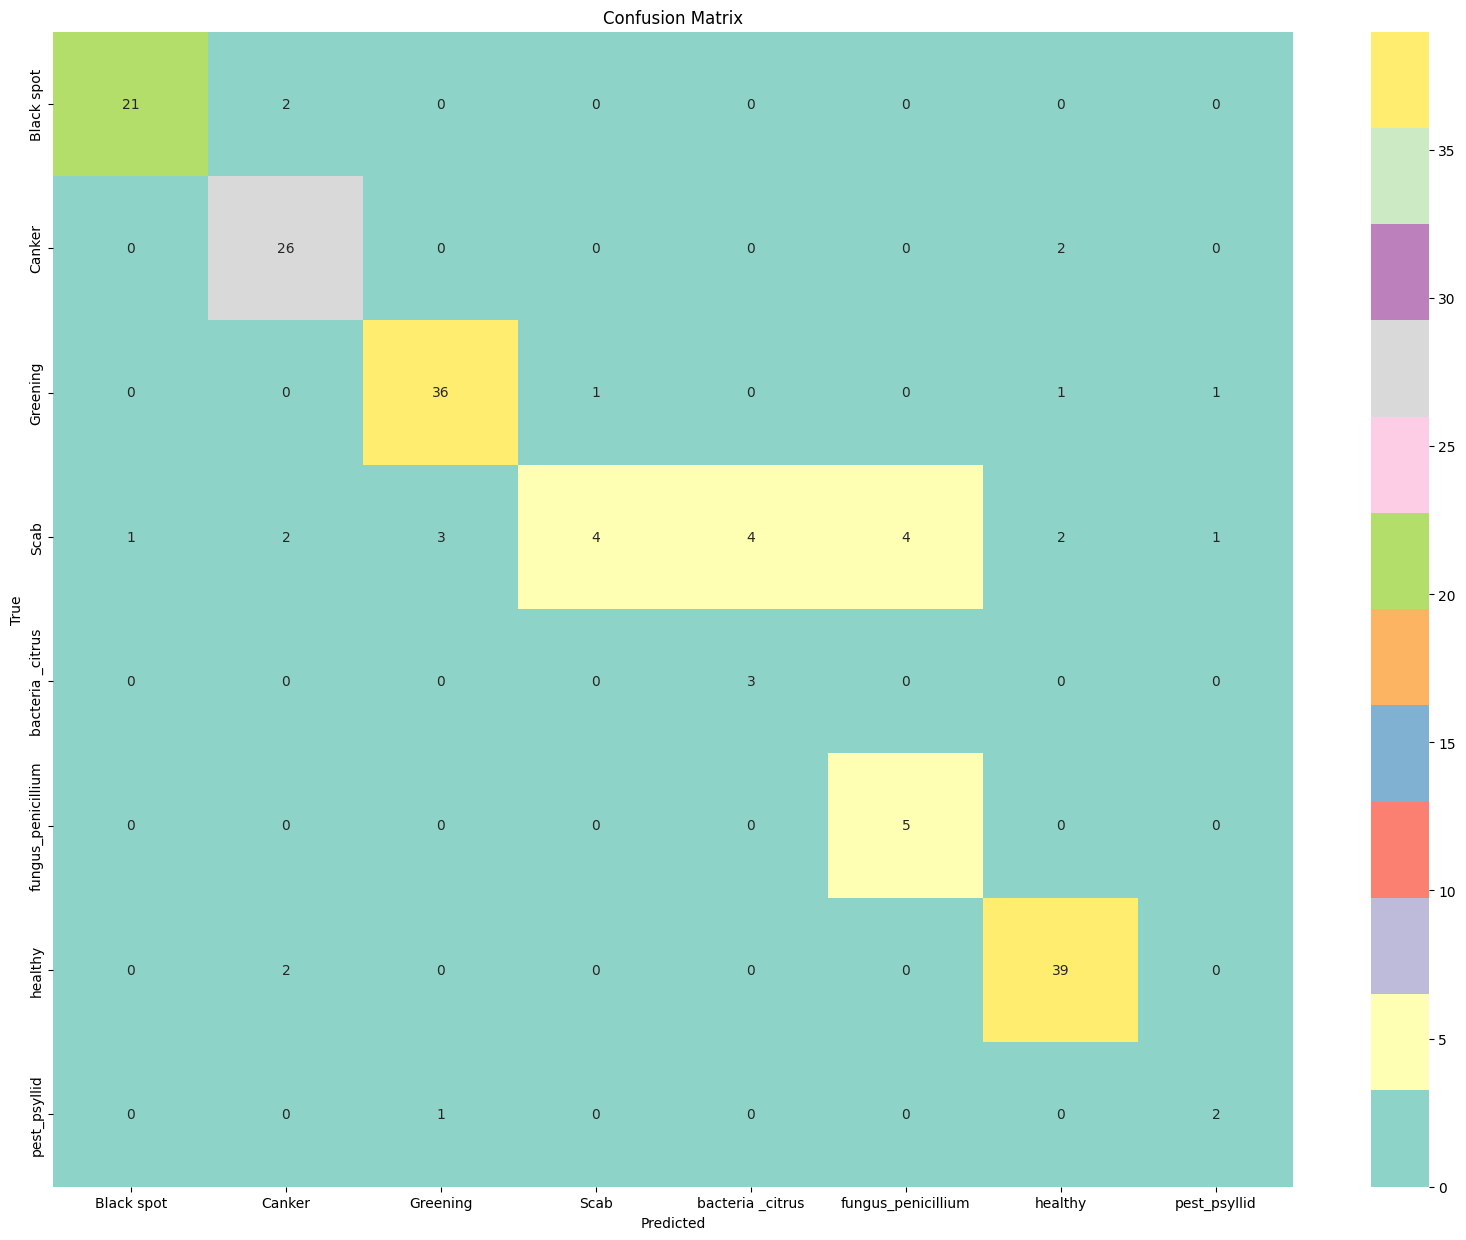

In [ ]:
# plot confusion matrix
plot_cm(cm, classes, title="Confusion Matrix")

## **3. Model Training with Augmentation**

- ***Resnet 18:*** (from previous modeling)
  - Train: Accuracy: 0.8020, Precision: 0.3146, Recall: 0.3389, F1 Score: 0.3203

  - Validation: Accuracy: 0.8366, Precision: 0.3274, Recall: 0.3545, F1 Score: 0.3351

  - Testing: Accuracy: 0.7898, Precision: 0.3054, Recall: 0.3479, F1 Score: 0.3218
  
- ***Efficient Net:***

  - Train: Accuracy: 0.9867, Precision: 0.9868, Recall: 0.9870, F1 Score: 0.9869
  
  - Validation: Accuracy: 0.9496, Precision: 0.8382, Recall: 0.8723, F1 Score: 0.8302

  - Testing: Accuracy: 0.8650, Precision: 0.7396, Recall: 0.7824, F1 Score: 0.7070

- ***Efficient Net B7:***

  - Train: Accuracy: Accuracy: 0.9388, Precision: 0.9406, Recall: 0.9418, F1 Score: 0.9411

  - Validation: Accuracy: 0.8921, Precision: 0.6728, Recall: 0.7459, F1 Score: 0.6955

  - Testing: Accuracy: 0.8282, Precision: 0.7433, Recall: 0.8338, F1 Score: 0.7307




### 3.3 Efficient Net B7




In [ ]:
# Efficient Net B7
config_ef_B7_aug = dict(
    resize = 256,
    crop = 240,
    augment= True,
    epochs = 50,
    batch_size = 32,
    lr = 0.001,
    dropout = 0.2,
    weights_path = 'weights_basic_efB7_aug.pth'
)

In [ ]:
# Get transformations
train_transform = get_transforms(config=config_ef_B7_aug, augment=config_ef_B7_aug['augment'])
val_test_transform = get_transforms(config=config_ef_B7_aug, augment=False)
# dataset
train_dataset = CustomDataset(root_dir=ROOT_DIR, split='train',resize=config_ef_B7_aug['resize'], transform=train_transform)
valid_dataset = CustomDataset(root_dir=ROOT_DIR, split='validation',resize=config_ef_B7_aug['resize'], transform=val_test_transform)
test_dataset = CustomDataset(root_dir=ROOT_DIR, split='test',resize=config_ef_B7_aug['resize'], transform=val_test_transform )
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=config_ef_B7_aug['batch_size'], shuffle = True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=config_ef_B7_aug['batch_size'], shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=config_ef_B7_aug['batch_size'], shuffle=False, num_workers=4)


In [ ]:
# Assign Weights to Each Sample
sample_weights = [class_weights[label] for _, label in train_loader.dataset] # The class weights are calculated in: 2.2.ResNet 18

# Convert list of sample weights to a Torch tensor
sample_weights = torch.tensor(sample_weights)

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Dataloaders setup
train_loader_balanced = DataLoader(train_dataset, batch_size=config_ef_B7_aug['batch_size'], sampler=sampler, num_workers=4)

In [ ]:
model_ef_B7_aug = models.efficientnet_b7(weights='DEFAULT', progress=True)
num_ftrs = model_ef_B7_aug.classifier[1].in_features
# Freeze the pre-trained model parameters
for param in model_ef_B7_aug.parameters():
    param.requires_grad = False
model_ef_B7_aug.classifier = nn.Sequential(
                nn.Dropout(p=config_ef_B7_aug["dropout"], inplace=True),
                nn.Linear(num_ftrs, 1024),
                nn.ReLU(),
                nn.Dropout(p=config_ef_B7_aug["dropout"]),
                nn.Linear(1024, num_classes)
            )
model_ef_B7_aug = model_ef_B7_aug.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:02<00:00, 110MB/s]


In [ ]:
# define optimizer and loss funtion
optimizer_ef_B7_aug = optim.AdamW(params=model_ef_B7_aug.parameters(), lr=config_ef_B7_aug['lr'])
loss_fn = nn.CrossEntropyLoss()
history_6  = training_pipeline(config=config_ef_B7_aug,
                  model = model_ef_B7_aug,
                  train_loader=train_loader_balanced,
                  valid_loader=valid_loader,
                  optimizer=optimizer_ef_B7_aug,
                  loss_fn=loss_fn,
                  early_stopping=es,
                  device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50
----------
Train - Loss: 0.9070, Accuracy: 0.7524, Precision: 0.7547, Recall: 0.7496, F1 Score: 0.7468
Validation - Loss: 1.0391, Accuracy: 0.6187, Precision: 0.5516, Recall: 0.4267, F1 Score: 0.3945


Epoch 2/50
----------
Train - Loss: 0.3433, Accuracy: 0.9042, Precision: 0.9033, Recall: 0.9050, F1 Score: 0.9037
Validation - Loss: 0.7320, Accuracy: 0.7554, Precision: 0.6572, Recall: 0.6564, F1 Score: 0.6191
Improvement found, counter reset to 0

Epoch 3/50
----------
Train - Loss: 0.2362, Accuracy: 0.9237, Precision: 0.9251, Recall: 0.9254, F1 Score: 0.9249
Validation - Loss: 0.4848, Accuracy: 0.8201, Precision: 0.6150, Recall: 0.7224, F1 Score: 0.6338
Improvement found, counter reset to 0

Epoch 4/50
----------
Train - Loss: 0.1645, Accuracy: 0.9503, Precision: 0.9491, Recall: 0.9498, F1 Score: 0.9492
Validation - Loss: 0.3995, Accuracy: 0.8921, Precision: 0.6702, Recall: 0.7727, F1 Score: 0.7012
Improvement found, counter reset to 0

Epoch 5/50
----------
Train - Loss: 0

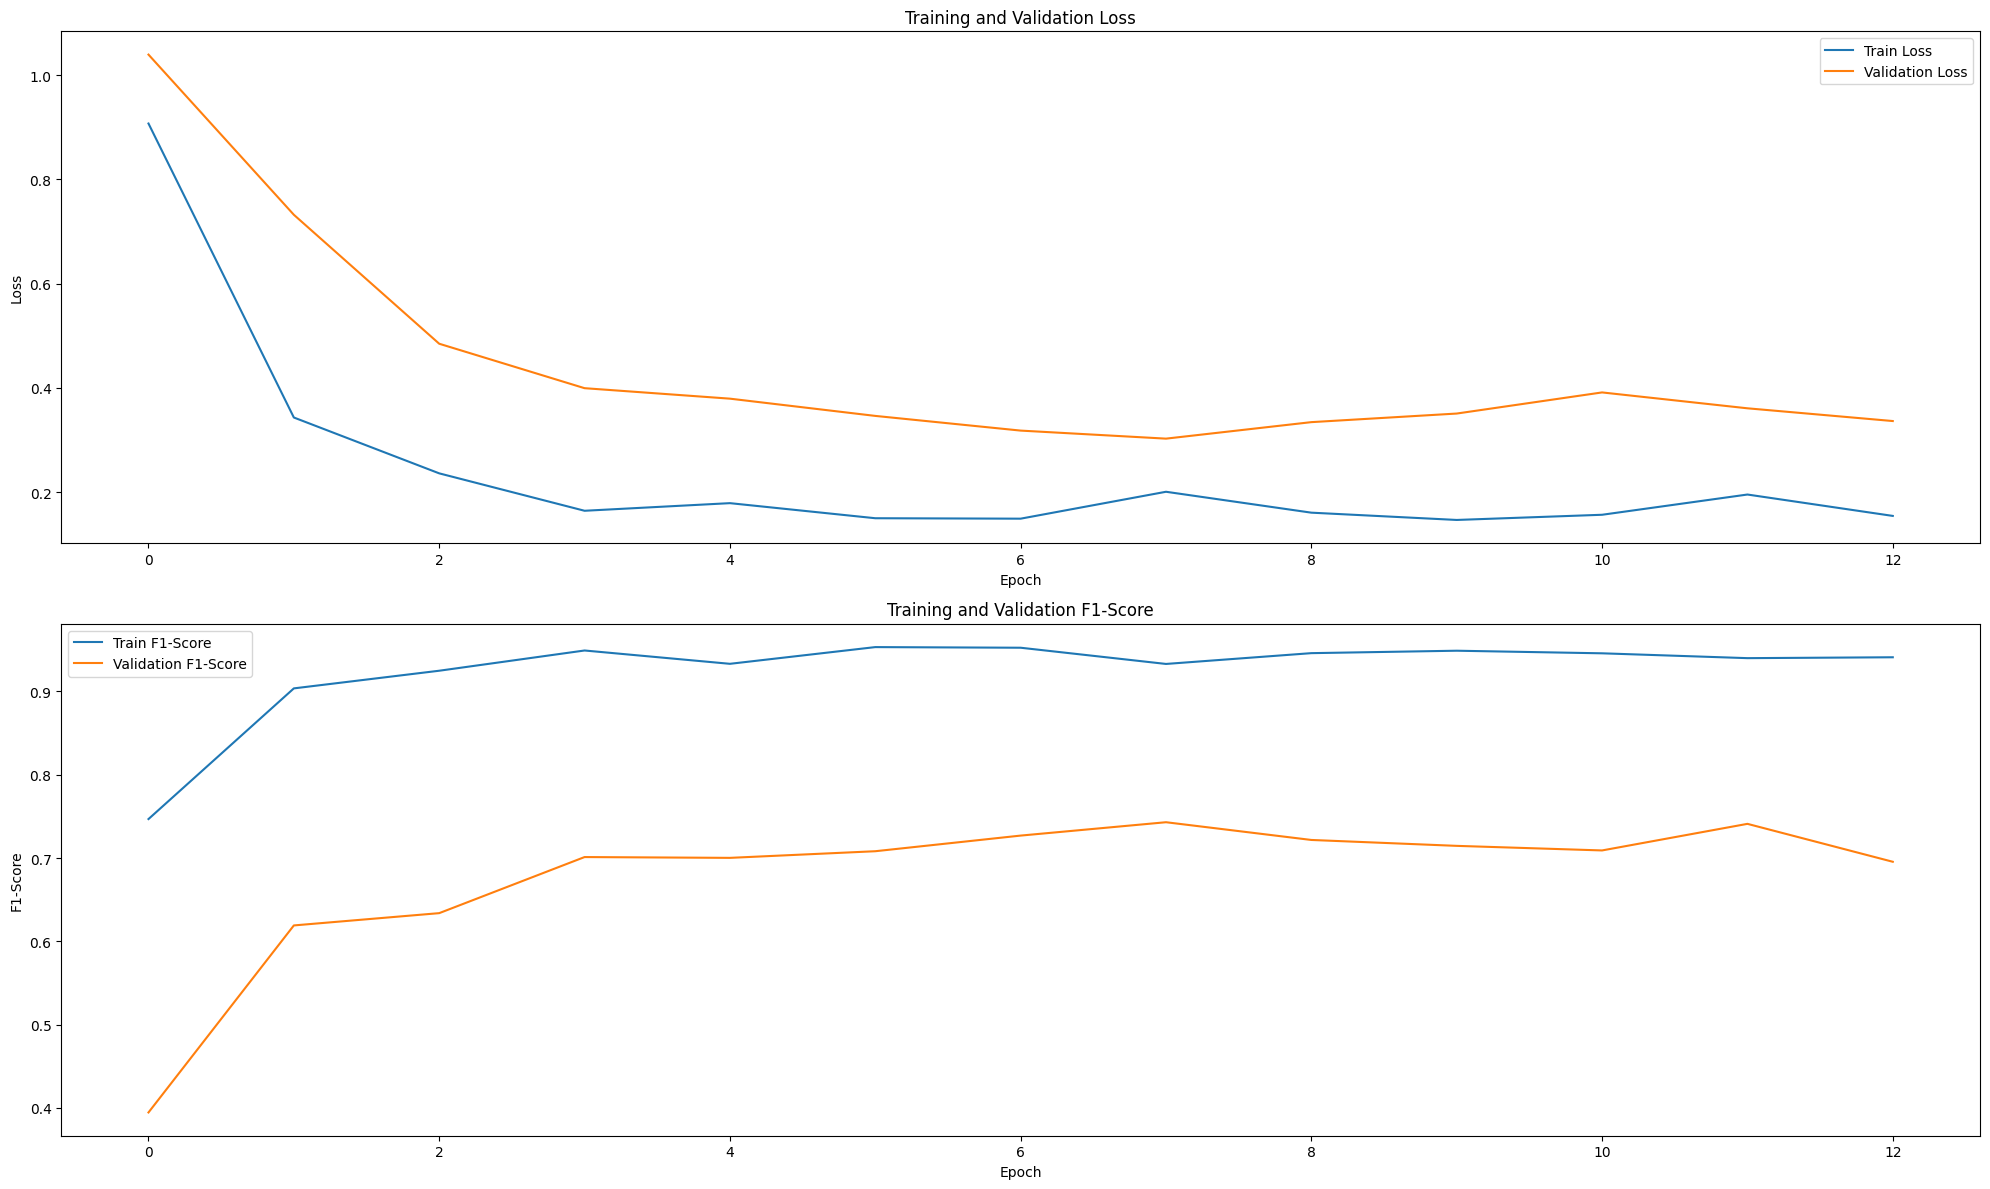

In [ ]:
plot_training_results(history=history_6)

In [ ]:
cm, f1_macro, precision, recall, accuracy, class_report = evaluate_model(model=model_ef_B7_aug, test_loader=test_loader, device='cuda')
print(f"Evaluation Results -  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_macro:.4f}")
print("Classification Report : \n")
print(class_report)

Evaluation Results -  Accuracy: 0.8282, Precision: 0.7433, Recall: 0.8338, F1 Score: 0.7307
Classification Report : 

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        23
           1       0.81      0.89      0.85        28
           2       0.86      0.92      0.89        39
           3       0.80      0.19      0.31        21
           4       0.30      1.00      0.46         3
           5       0.80      0.80      0.80         5
           6       0.93      0.95      0.94        41
           7       0.50      1.00      0.67         3

    accuracy                           0.83       163
   macro avg       0.74      0.83      0.73       163
weighted avg       0.85      0.83      0.81       163



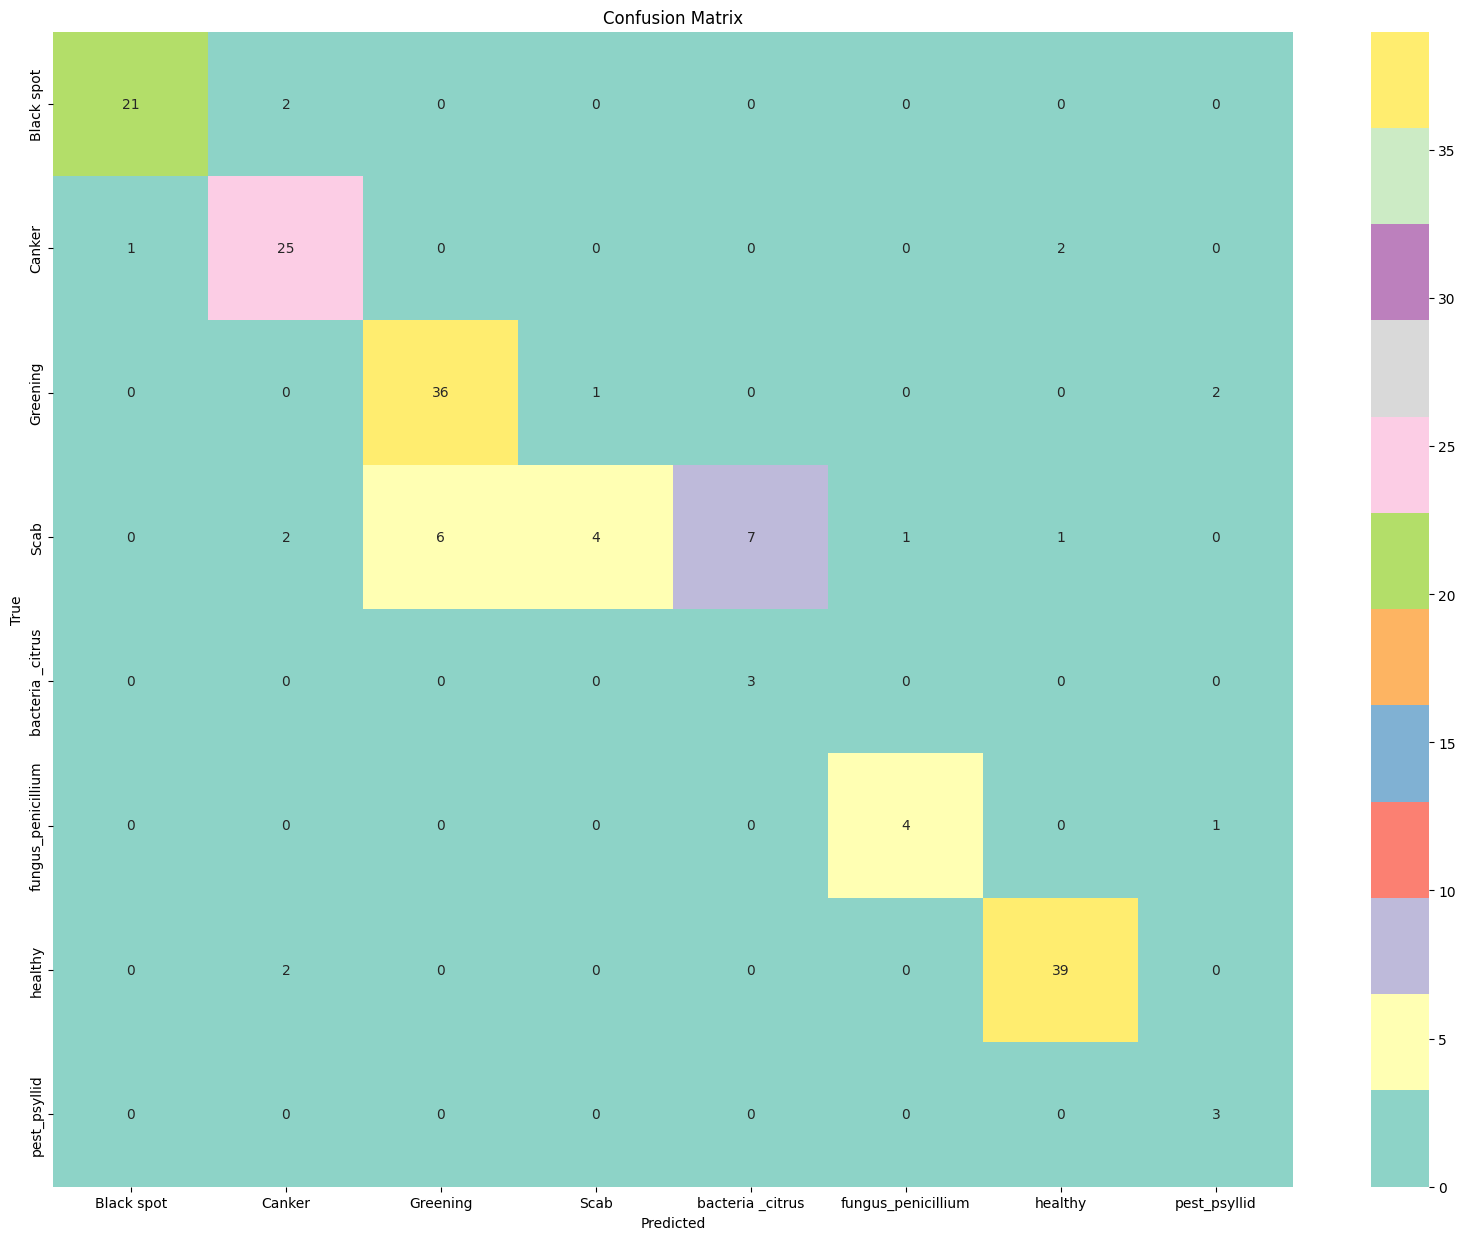

In [ ]:
# plot confusion matrix
plot_cm(cm, classes, title="Confusion Matrix")

### **3.4. Efficient Net**

In [ ]:
# tweak these and experiment with different values.
config_ef_aug = dict(
    resize =256,
    crop = 240,
    augment= True,
    epochs = 50,
    batch_size = 32,
    lr = 0.001,
    dropout = 0.2,
    weights_path = 'weights_augmented_ef.pth'
)

In [ ]:
# Get transformations
train_transform = get_transforms(config=config_ef_aug, augment=config_ef_aug['augment'])
val_test_transform = get_transforms(config=config_ef_aug, augment=False)
# dataset
train_dataset = CustomDataset(root_dir=ROOT_DIR, split='train',resize=config_ef_aug['resize'], transform=train_transform)
valid_dataset = CustomDataset(root_dir=ROOT_DIR, split='validation',resize=config_ef_aug['resize'], transform=val_test_transform)
test_dataset = CustomDataset(root_dir=ROOT_DIR, split='test',resize=config_ef_aug['resize'], transform=val_test_transform )
# dataloaders
train_loader_balanced = DataLoader(train_dataset, batch_size=config_ef_aug['batch_size'], shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=config_ef_aug['batch_size'], shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=config_ef_aug['batch_size'], shuffle=False, num_workers=4)

In [ ]:
# Assign Weights to Each Sample
sample_weights = [class_weights[label] for _, label in train_loader.dataset] # The class weights are calculated in: 2.2.ResNet 18

# Convert list of sample weights to a Torch tensor
sample_weights = torch.tensor(sample_weights)

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Dataloaders setup
train_loader_balanced = DataLoader(train_dataset, batch_size=config_ef_aug['batch_size'], sampler=sampler, num_workers=4)

In [ ]:
model_ef_aug = models.efficientnet_b1(weights='DEFAULT', progress=True)
num_ftrs = model_ef_aug.classifier[1].in_features
# Freeze the pre-trained model parameters
for param in model_ef_aug.parameters():
    param.requires_grad = False
model_ef_aug.classifier = nn.Sequential(
                nn.Dropout(p=config_ef_aug["dropout"], inplace=True),
                nn.Linear(num_ftrs, 1024),
                nn.ReLU(),
                nn.Dropout(p=config_ef_aug["dropout"]),
                nn.Linear(1024, num_classes)
            )
model_ef_aug = model_ef_aug.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 145MB/s]


In [ ]:
# define optimizer and loss funtion
optimizer_ef_aug = optim.Adam(params=model_ef_aug.parameters(), lr=config_ef_aug['lr'])
loss_fn = nn.CrossEntropyLoss()

In [ ]:
history_5  = training_pipeline(config=config_ef_aug,
                  model = model_ef_aug,
                  train_loader=train_loader_balanced,
                  valid_loader=valid_loader,
                  optimizer=optimizer_ef_aug,
                  loss_fn=loss_fn,
                  early_stopping=None,
                  device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50
----------
Train - Loss: 0.9372, Accuracy: 0.7870, Precision: 0.7957, Recall: 0.7850, F1 Score: 0.7736
Validation - Loss: 0.4710, Accuracy: 0.8849, Precision: 0.7386, Recall: 0.8621, F1 Score: 0.7359

Epoch 2/50
----------
Train - Loss: 0.2486, Accuracy: 0.9281, Precision: 0.9267, Recall: 0.9277, F1 Score: 0.9266
Validation - Loss: 0.3388, Accuracy: 0.8777, Precision: 0.6997, Recall: 0.8241, F1 Score: 0.7304

Epoch 3/50
----------
Train - Loss: 0.2126, Accuracy: 0.9370, Precision: 0.9369, Recall: 0.9382, F1 Score: 0.9372
Validation - Loss: 0.2586, Accuracy: 0.9209, Precision: 0.7237, Recall: 0.8544, F1 Score: 0.7673

Epoch 4/50
----------
Train - Loss: 0.1357, Accuracy: 0.9547, Precision: 0.9563, Recall: 0.9546, F1 Score: 0.9551
Validation - Loss: 0.2545, Accuracy: 0.9137, Precision: 0.7345, Recall: 0.7919, F1 Score: 0.7407

Epoch 5/50
----------
Train - Loss: 0.1175, Accuracy: 0.9565, Precision: 0.9568, Recall: 0.9561, F1 Score: 0.9563
Validation - Loss: 0.2209, Accuracy: 0

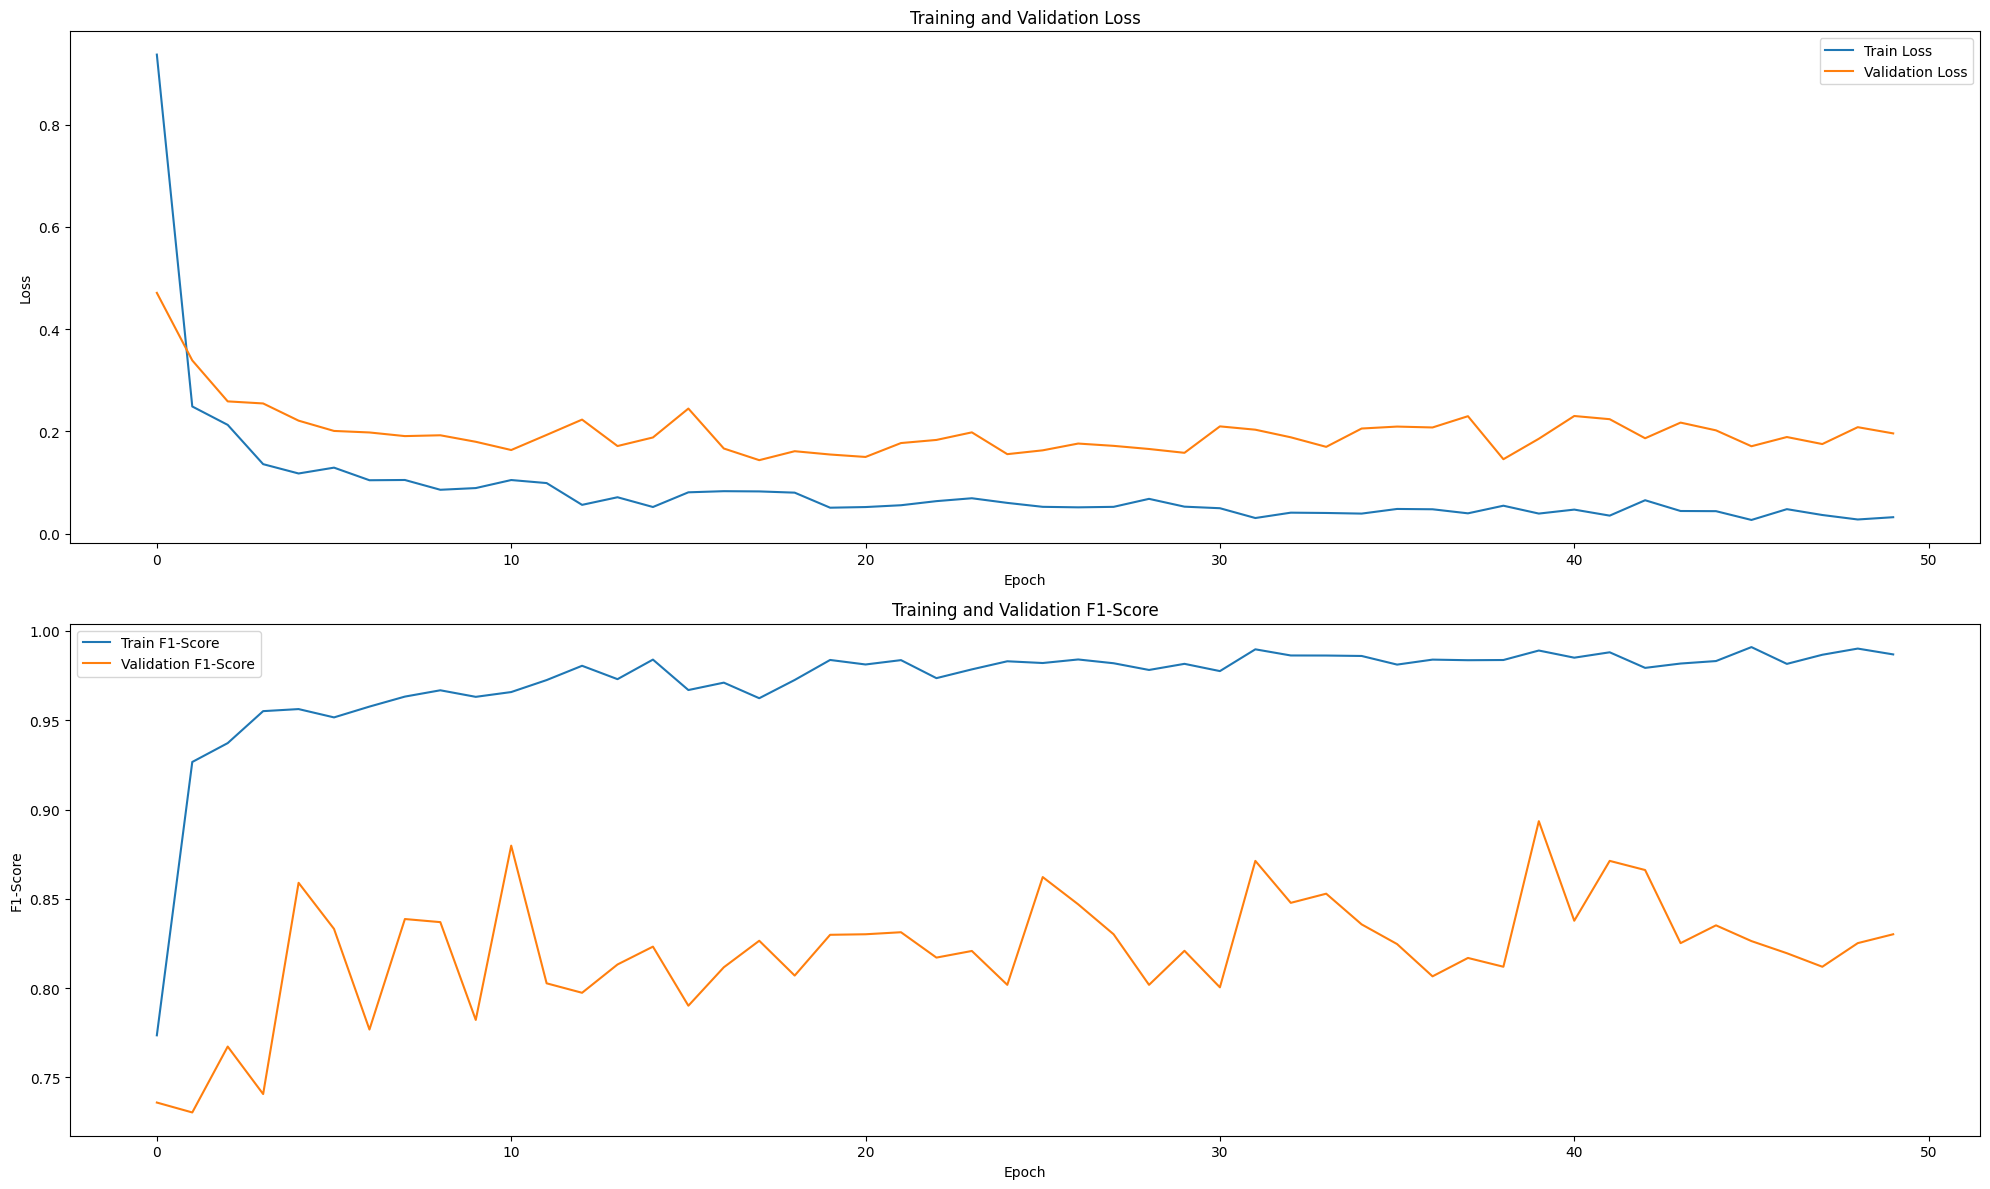

In [ ]:
plot_training_results(history=history_5)

In [ ]:
cm, f1_macro, precision, recall, accuracy, class_report = evaluate_model(model=model_ef_aug, test_loader=test_loader, device='cuda')
print(f"Evaluation Results -  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_macro:.4f}")
print("Classification Report : \n")
print(class_report)

Evaluation Results -  Accuracy: 0.8650, Precision: 0.7396, Recall: 0.7824, F1 Score: 0.7070
Classification Report : 

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        23
           1       0.93      1.00      0.97        28
           2       0.95      0.97      0.96        39
           3       1.00      0.24      0.38        21
           4       0.25      0.67      0.36         3
           5       0.67      0.80      0.73         5
           6       0.95      1.00      0.98        41
           7       0.25      0.67      0.36         3

    accuracy                           0.87       163
   macro avg       0.74      0.78      0.71       163
weighted avg       0.91      0.87      0.86       163



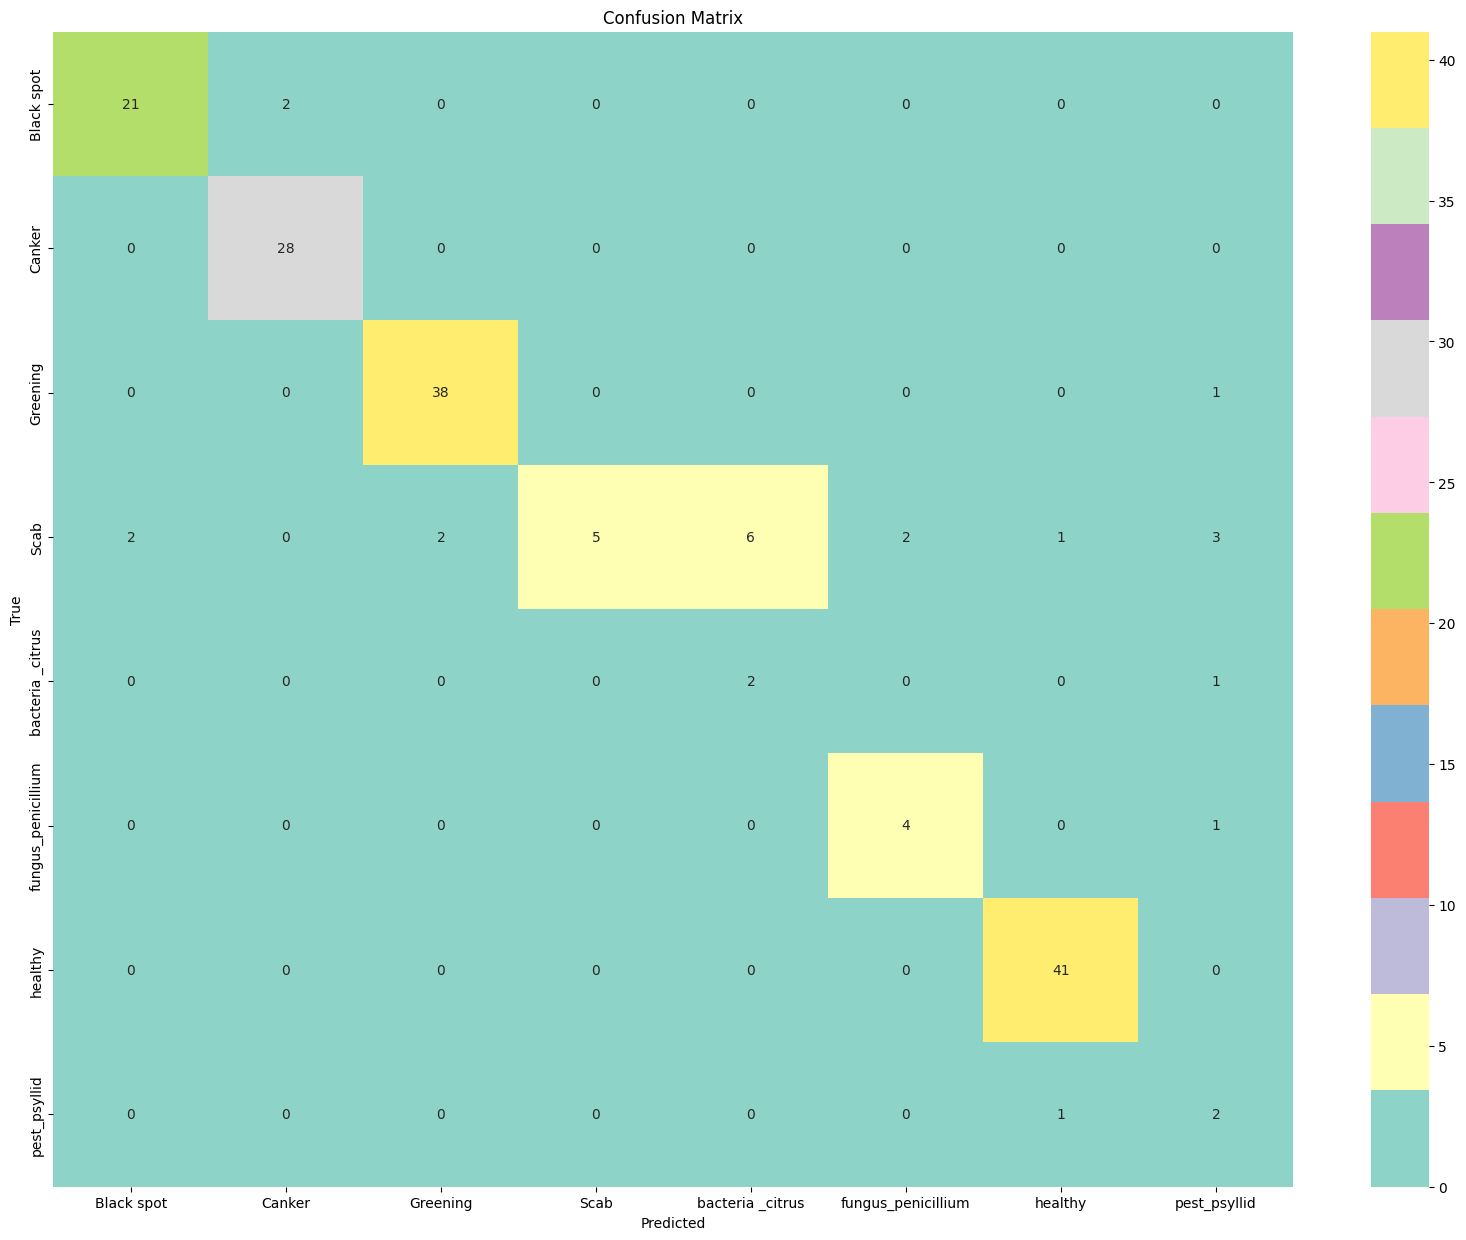

In [ ]:
# plot confusion matrix
plot_cm(cm, classes, title="Confusion Matrix")

# **III. Prediction pipeline**
Here we use the saved model weights and *Efficient Net B1 with Augmentation* model to make a prediction on a randomly selected image of an orange fruit.

Steps in the prediction pipeline:
1.Load the model's pre-trained weights from a saved file
2. Randomly pick an image of an orange fruit from our dataset.
3. Normalize the image to ensure its pixel values match what the model expects.
4. After preprocessing, the image will be passed through the model the Efficinet Net model, which will output a probability distribution over the possible classes.
5. Finally, we will choose the class with the highest probability as the prediction, and then display both the image and the predicted disease label.

In [1]:
## 1. Load model with pre-trained weights

In [ ]:
def load_model_weights(model, weights_path, device='cpu'):
    """
    Loads the weights from a saved .pth file into a PyTorch model and checks if the weights are loaded properly.

    Parameters:
    - model: The PyTorch model to which the weights will be loaded.
    - weights_path: The path to the .pth file containing the model weights.
    - device: The device on which the model will be loaded ('cpu' or 'cuda').

    Returns:
    - model: The PyTorch model with loaded weights.
    """
    # Ensure the model is on the correct device
    model = model.to(device)

    # Load the weights into a variable
    state_dict = torch.load(weights_path, map_location=device)

    # Load the state dict into the model
    model.load_state_dict(state_dict)

    # Verifying successful loading
    try:
        model.load_state_dict(state_dict)
        print("Model weights have been successfully loaded.")
    except Exception as e:
        print("Failed to load model weights:", e)

    return model


In [ ]:
num_classes = 8
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setting up the classifier (assuming it has already been defined)
model_ef_aug.classifier = nn.Sequential(
    nn.Dropout(p=config_ef_aug["dropout"], inplace=True),
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Dropout(p=config_ef_aug["dropout"]),
    nn.Linear(1024, num_classes)
)

# Load the model weights
weights_path = '/content/drive/MyDrive/Orange Task 3/weights_augmented_ef.pth'
model_ef_aug = load_model_weights(model_ef_aug, weights_path, device)

Model weights have been successfully loaded.


In [ ]:
def predict_single_image(image_path, model, device):
    # Load the image
    image = Image.open(image_path)

    # Apply transformations
    test_transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
       ])

    image_tr = test_transform(image=np.array(image))['image']
    image_tr = torch.tensor(image_tr).unsqueeze(0).to(device)

    # Make predictions
    with torch.no_grad():
        output = model(image_tr)
        probabilities = torch.softmax(output, dim=1)
        _, predicted_class = torch.max(probabilities, 1)

    return predicted_class.item(), probabilities[0, predicted_class].item()

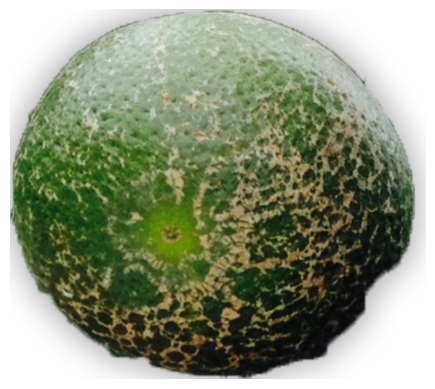

In [ ]:
random.seed(8)
test_path = '/content/drive/MyDrive/Milan-Urban-Farming/Task3-Smart Pest Management/Data collection/Image Collection/orange - Swathy/Orange fruit/Scab'
image_files = glob.glob(os.path.join(test_path,'*.jpg'))
# Select a random image file
random_image_file = random.choice(image_files)

# Load and display the random image using matplotlib
image = imread(random_image_file)
plt.imshow(image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()


In [ ]:
class_map.values()

dict_values(['Black spot', 'Canker', 'Greening', 'Scab', 'bacteria _citrus', 'fungus_penicillium', 'healthy', 'pest_psyllid'])

In [ ]:
print('Image_name : ',random_image_file)
img_path = random_image_file
predicted_label, _ = predict_single_image(image_path=img_path ,model=model_ef_aug, device='cuda')
print(f"Predicted Label: {class_map[predicted_label]}")

Image_name :  /content/drive/MyDrive/Milan-Urban-Farming/Task3-Smart Pest Management/Data collection/Image Collection/orange - Swathy/Orange fruit/Scab/53.jpg
Predicted Label: Scab
